### Установка transformers и torch


In [ ]:
!pip install transformers -q

In [ ]:
!pip install --upgrade nltk pyspellchecker gensim pandarallel -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.8 MB/s eta 0:00:00


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import pandarallel  # Может не работать на Windows
pandarallel.pandarallel.initialize(nb_workers=6, progress_bar=True)
import matplotlib.pyplot as plt
from wordcloud import WordCloud



from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Загрузка предобученного DistilBERT



In [ ]:
# Создаём объекты классов DistilBERT + DistilBERTTokenizer
model_class, tokenizer_class = ppb.DistilBertModel, ppb.DistilBertTokenizer

# Загружаем веса

tokenizer = tokenizer_class.from_pretrained('distilbert-base-uncased')
model = model_class.from_pretrained('distilbert-base-uncased')
# tokenizer = tokenizer_class.from_pretrained('assemblyai/distilbert-base-uncased-sst2')
# model = model_class.from_pretrained('assemblyai/distilbert-base-uncased-sst2')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Токенизация

Токенизация в BERT (Bidirectional Encoder Representations from Transformers) — это процесс преобразования текста в формат, который можно подать на вход модели. BERT использует специализированную токенизацию, основанную на методе WordPiece:

Разделение на слова: Текст сначала делится на отдельные слова или субслова. Например, предложение "I love machine learning" может быть разделено на ["I", "love", "machine", "learning"].

Разделение на подслова: Слова могут быть дополнительно разбиты на подслова, если они не встречались в словаре модели. Например, слово "learning" может быть разбито на ["learn", "##ing"], где "##ing" — это суффикс, указывающий на то, что это продолжение предыдущего подслова.

Преобразование в идентификаторы: Каждое подслово преобразуется в идентификатор, который соответствует его позиции в словаре модели BERT. Эти идентификаторы затем подаются на вход модели.

Добавление специальных токенов: Для поддержки задач, таких как сегментация предложений и маскировка, добавляются специальные токены:
[CLS] (для классификации, добавляется в начало текста)
[SEP] (для разделения предложений или частей текста)

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv',index_col=0)

In [ ]:
df['text'] = df['text'].str.lower()

In [ ]:
import re
pattern = re.compile('<.*?>')

In [ ]:
df['text'] = df['text'].parallel_apply(lambda line: pattern.sub('', line))

In [ ]:
df.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


In [ ]:
# Создаем случайную подвыборку из датафрейма df
#  (на всем наборе данных колаб не работает)

df = df.sample(n=2000, random_state=12345)

df.head()

,text,toxic
109583,expert categorizers \n\nwhy is there no menti...,0
105077,"""\n\n noise \n\nfart* talk. """,1
82244,"an indefinite block is appropriate, even for a...",0
18740,i don't understand why we have a screenshot of...,0
128310,"hello! some of the people, places or things yo...",0


In [ ]:
sample = df[164:165]
sample

,text,toxic
75081,:the bart simpson show\nwelcome to wikipedia! ...,0


In [ ]:
tokenized = df['text'].apply((lambda x: tokenizer.encode(x,
                                                           add_special_tokens=True,
                                                           truncation=True,
                                                           max_length=128)))

In [ ]:
tokenized.shape

(2000,)

In [ ]:
len(tokenized.iloc[799])

52

In [ ]:
min_len = 128
for p, i in enumerate(tokenized.values):
    if len(i) < min_len:
        min_len = len(i)
        print(p)

0
1
7
77
228
508


### Padding

добавление дополнительных элементов в последовательность - чтобы длина у всех эмбедингов была одинаковая

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

In [ ]:
max_len

128

In [ ]:
np.array(padded).shape

(2000, 128)

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 128)

In [ ]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

### Получение признаков (эмбеддингов)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
type(features)

numpy.ndarray

In [ ]:
features.shape

### Обучение логистической регрессии

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, df['toxic'], test_size=0.25)

In [ ]:
X_train.shape, X_test.shape

((1500, 768), (500, 768))

In [ ]:
y_train.value_counts()

,count
toxic,
0,1346
1,154


In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

LogisticRegression()

### Оценим модель

In [ ]:
pred_bert_lr = lr_clf.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_bert_lr))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       440
           1       0.76      0.48      0.59        60

    accuracy                           0.92       500
   macro avg       0.85      0.73      0.77       500
weighted avg       0.91      0.92      0.91       500



### Визуализация

По всему датасету

<function matplotlib.pyplot.show(close=None, block=None)>

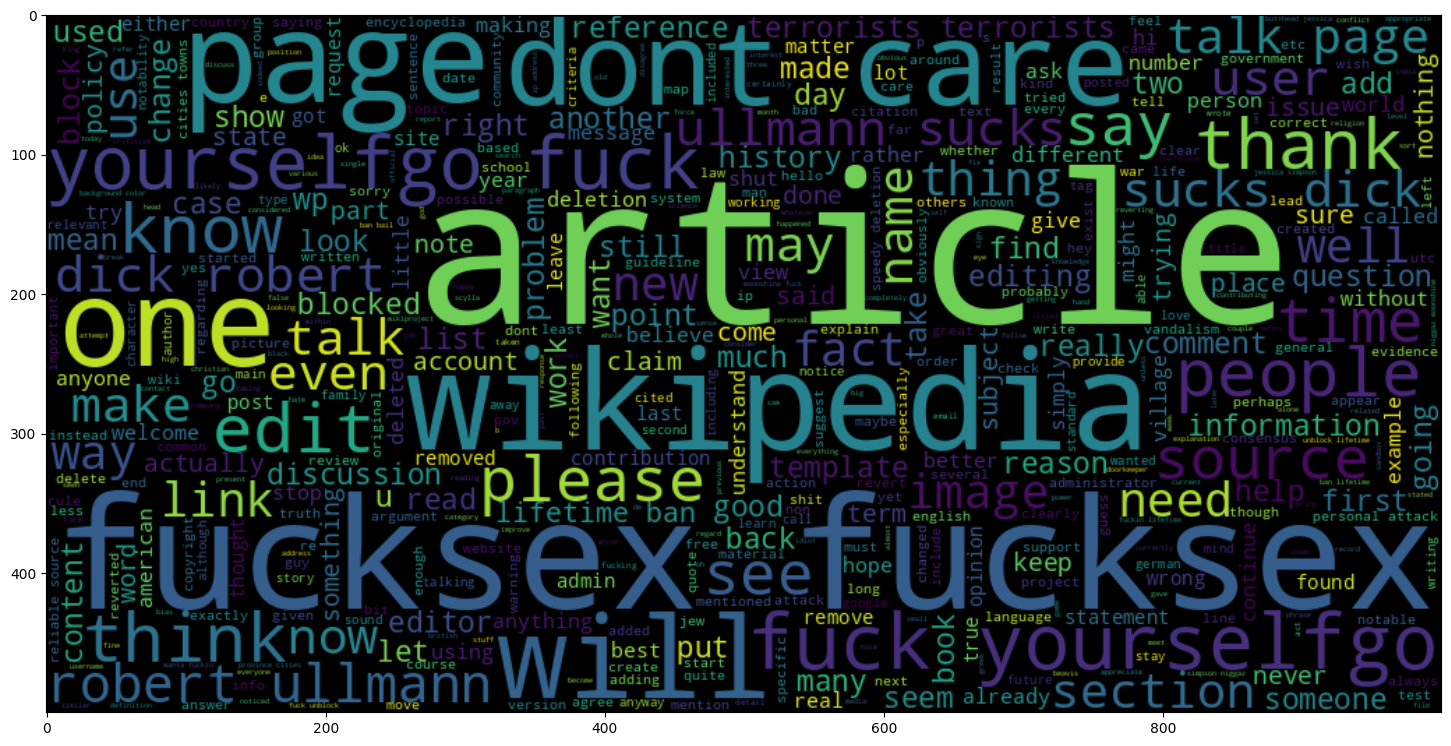

In [37]:
plt.figure(figsize=(18,18))
text = ' '.join(df['text'].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.show

Токсичные слова

<function matplotlib.pyplot.show(close=None, block=None)>

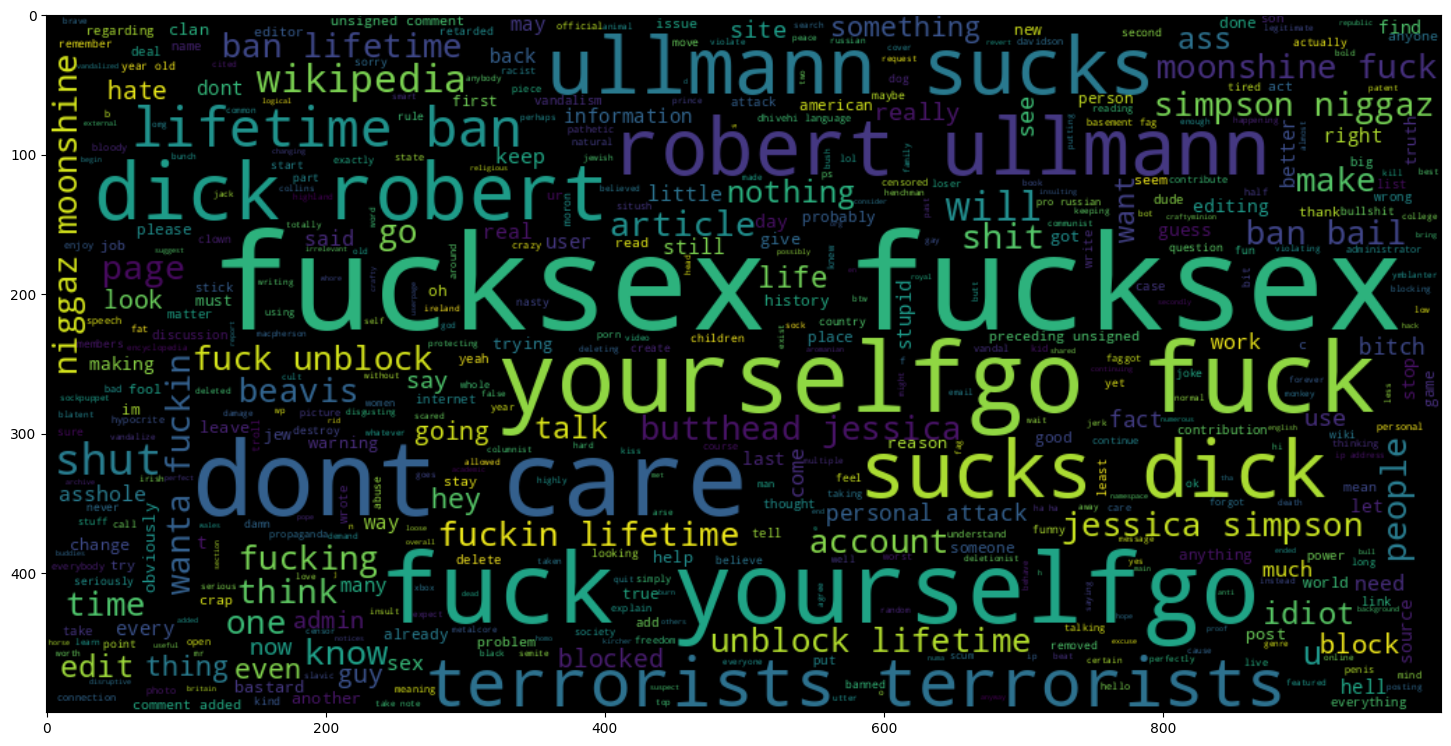

In [38]:
plt.figure(figsize=(18,18))
text = ' '.join(df[df['toxic']==1]['text'].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.show

Хорошие слова

<function matplotlib.pyplot.show(close=None, block=None)>

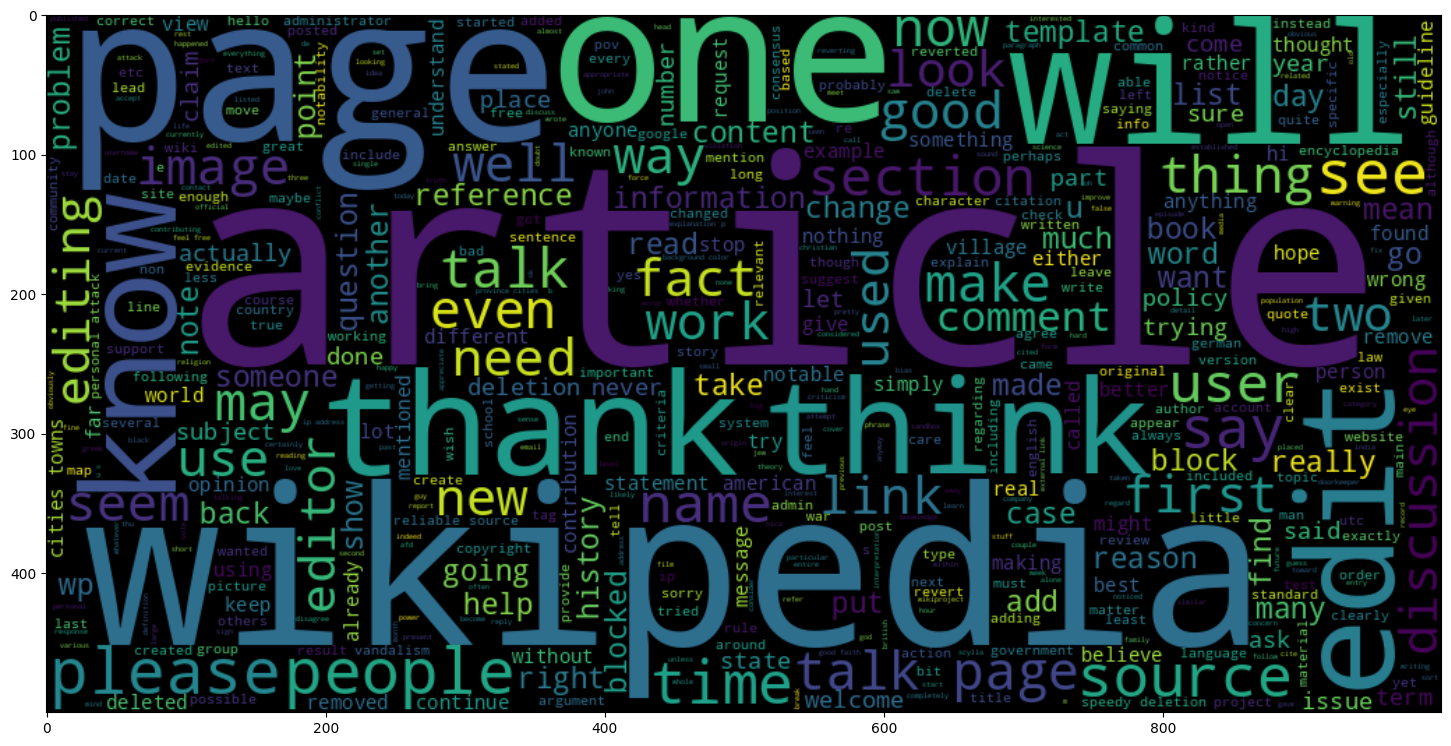

In [39]:
plt.figure(figsize=(18,18))
text = ' '.join(df[df['toxic']==0]['text'].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.show